<a href="https://colab.research.google.com/github/unique-subedi/gene-expression/blob/main/Xinhe_gene_expression_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import datetime
import time
import math
import numpy as np
from numpy import linalg as LA
import pandas as pd
import urllib.request
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests

In [2]:
!pip install qnorm
import qnorm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install pyreadr
import pyreadr
urllib.request.urlretrieve("https://raw.githubusercontent.com/unique-subedi/gene-expression/main/data/brain.rda", "brain.rda")
brain = pyreadr.read_r("brain.rda")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 363 kB 5.2 MB/s 


In [4]:
expression = pd.DataFrame(brain["expression"])
genes = pd.DataFrame(brain["genes"])
samples = pd.DataFrame(brain["samples"])

In [ ]:
expression.head()

,1000_at,1001_at,1002_f_at,1003_s_at,1004_at,1005_at,1006_at,1007_s_at,1008_f_at,1009_at,...,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,AFFX-YEL002c/WBP1_at,AFFX-YEL018w/_at,AFFX-YEL021w/URA3_at,AFFX-YEL024w/RIP1_at,AFFX-hum_alu_at
01_a_D_f_2.CEL,9.521934,7.453767,7.045636,7.743690,7.728274,8.081243,6.927978,9.294152,8.888816,8.290944,...,7.065597,6.803698,6.631766,6.981474,7.003319,6.999630,7.005495,6.864895,7.030665,14.394582
01_a_I_f_2.CEL,10.930684,9.455482,9.233291,9.777128,9.612399,9.845444,9.149639,10.580062,11.505571,9.846817,...,9.366604,9.067484,8.945584,9.118070,9.137492,9.067202,9.129742,9.256544,9.171725,15.494106
01_a_M_f_1.CEL,6.852731,5.298974,5.033266,6.040661,5.890083,5.810144,5.098923,6.240855,7.280948,6.124910,...,5.374457,5.165619,5.032617,5.382904,5.509690,5.113946,5.273243,5.321357,5.321636,12.856782
01_c_D_f_1.CEL,7.285181,6.258114,6.119443,6.631768,6.744592,6.589478,6.156638,7.417750,8.663882,8.203275,...,6.332162,6.278864,6.108778,6.341791,6.339638,6.167335,6.170734,6.734936,6.275118,13.683484
01_c_I_f_2.CEL,11.224543,9.800931,9.407753,10.113212,9.871853,10.495533,9.449701,11.084619,11.969619,10.479006,...,9.443910,9.242560,9.272848,9.435175,9.448927,9.395768,9.306998,9.863770,9.404475,15.494106


In [ ]:
genes.head()

,sym,chrom
rownames,,
1000_at,MAPK3,16
1001_at,TIE1,1
1002_f_at,CYP2C19,10
1003_s_at,CXCR5,11
1004_at,CXCR5,11


In [ ]:
samples.head()

,patient,sex,region,lab,chip.version
rownames,,,,,
01_a_D_f_2.CEL,patient_01,female,A.C. cortex,Davis,v2
01_a_I_f_2.CEL,patient_01,female,A.C. cortex,Irvine,v2
01_a_M_f_1.CEL,patient_01,female,A.C. cortex,Michigan,v1
01_c_D_f_1.CEL,patient_01,female,cerebellum,Davis,v1
01_c_I_f_2.CEL,patient_01,female,cerebellum,Irvine,v2


In [5]:
# normalization
genes.at["AFFX-BioDn-3_at", 'chrom'] = float("Nan")
genes_control = genes[['AFFX' in s for s in genes.index]]
genes_control = genes_control[['HUM' not in s for s in genes_control.index]]
genes_control = genes_control[['hum' not in s for s in genes_control.index]]
genes_bac_index = genes_control[genes_control.chrom.isnull() & genes_control.sym.isnull()].index

genes_Y_crom = genes[genes.chrom == "Y"].index
genes_bac_index = genes[genes.sym.isnull() & genes.chrom.isnull()].index
print(genes_bac_index.shape)
mean_bac_exp = expression[genes_bac_index].mean(axis=1)
std_bac_exp = expression[genes_bac_index].std(axis=1)
expression_norm =  (expression - mean_bac_exp.values[:, None]).divide(std_bac_exp, axis=0)
expression_qnorm = qnorm.quantile_normalize(expression, axis=0)

(869,)


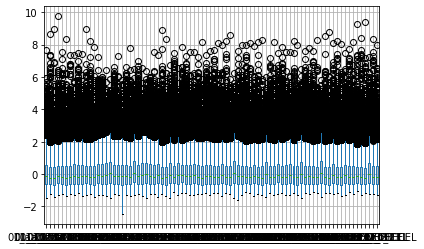

In [6]:
# expression.T.boxplot()
expression_norm.T.boxplot()
# expression_qnorm.T.boxplot()

In [7]:
express_samp = pd.concat([expression_norm, samples], axis=1)

express_samp.head()

,1000_at,1001_at,1002_f_at,1003_s_at,1004_at,1005_at,1006_at,1007_s_at,1008_f_at,1009_at,...,AFFX-YEL002c/WBP1_at,AFFX-YEL018w/_at,AFFX-YEL021w/URA3_at,AFFX-YEL024w/RIP1_at,AFFX-hum_alu_at,patient,sex,region,lab,chip.version
01_a_D_f_2.CEL,2.172643,-0.155109,-0.614466,0.171203,0.153853,0.551124,-0.746892,1.916271,1.460059,0.787146,...,-0.666247,-0.659646,-0.817893,-0.631316,7.656880,patient_01,female,A.C. cortex,Davis,v2
01_a_I_f_2.CEL,1.965351,-0.200480,-0.526691,0.271747,0.029899,0.372047,-0.649506,1.450583,2.809377,0.374062,...,-0.770536,-0.678717,-0.492553,-0.617079,8.665178,patient_01,female,A.C. cortex,Irvine,v2
01_a_M_f_1.CEL,1.401793,-0.553507,-0.887883,0.379857,0.190364,0.089766,-0.805258,0.631787,1.940675,0.485879,...,-0.786352,-0.585888,-0.525340,-0.524989,8.957491,patient_01,female,A.C. cortex,Michigan,v1
01_c_D_f_1.CEL,0.816036,-0.619040,-0.812801,-0.096950,0.060694,-0.156041,-0.760829,1.001269,2.742435,2.098850,...,-0.745883,-0.741134,0.047202,-0.595283,9.756111,patient_01,female,cerebellum,Davis,v1
01_c_I_f_2.CEL,1.811874,-0.110944,-0.641994,0.310842,-0.015152,0.827228,-0.585337,1.622885,2.818220,0.804906,...,-0.658181,-0.778081,-0.026070,-0.646422,7.578609,patient_01,female,cerebellum,Irvine,v2


In [27]:
express_samp_UM = express_samp[express_samp.lab == "Irvine"]

p_values = pd.DataFrame()

# for each tissue, permute the 10 outcomes, 
# use the difference-in-means as the test statistic
for tissue in express_samp_UM["region"].unique():
  print(tissue)
  express_samp_UM_new = express_samp_UM[(express_samp_UM.region == tissue)]
  express_samp_UM_new = pd.concat([express_samp_UM_new, pd.DataFrame(columns=['perm'])], axis=1)

  df_male = express_samp_UM_new[express_samp_UM_new.sex == "male"]
  df_female = express_samp_UM_new[express_samp_UM_new.sex == "female"]

  male_mean = df_male.mean()
  female_mean = df_female.mean()

  diff = pd.DataFrame(male_mean - female_mean)
  for comb in combinations(range(10), 5):
    #print(comb)
    express_samp_UM_new.perm = [0] * len(express_samp_UM_new)

    express_samp_UM_new.perm.iloc[list(comb)] = 1

    df_male = express_samp_UM_new[express_samp_UM_new.perm == 1]
    df_female = express_samp_UM_new[express_samp_UM_new.perm == 0]

    male_mean = df_male.mean()
    female_mean = df_female.mean()

    diff = pd.concat([diff, male_mean - female_mean], axis=1)
    #print(diff.shape)
  
  # compare columns and get p-values
  diff = diff.abs()
  for j in range(252):
    diff.iloc[:,j+1] = diff.iloc[:,0] <= diff.iloc[:,j+1]
  p_values = pd.concat([p_values, diff.iloc[:,1:].mean(axis=1)], axis=1)

p_values.head()
p_values = p_values.drop(labels=['perm'], axis=0)

A.C. cortex


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3

cerebellum
D.L.P.F. cortex


In [37]:
print(sum(p_values.mean(axis=1) <= 0.05))
print(1/252)
p_values[p_values.mean(axis=1) <= 0.2]
p_values[p_values.min(axis=1) <= 0.008]

8
0.003968253968253968


,A.C. cortex,cerebellum,D.L.P.F. cortex
1012_at,0.333333,0.007937,0.920635
1042_at,0.365079,0.007937,0.285714
1127_at,0.587302,0.007937,0.404762
1181_at,0.182540,0.388889,0.007937
1307_at,0.007937,0.380952,0.714286
...,...,...,...
782_at,0.857143,0.301587,0.007937
842_at,0.460317,0.007937,0.865079
882_at,0.507937,0.007937,0.468254
902_at,0.158730,0.007937,0.817460


In [12]:
bonferr = multipletests(p_values.iloc[:,0], method='fdr_bh')[0]
sum(bonferr)

0

In [32]:
p_values.columns = ['A.C. cortex', 'cerebellum', 'D.L.P.F. cortex']
p_values_mean = pd.concat([p_values, pd.DataFrame(p_values.mean(axis=1), columns=['mean'])], axis=1)
p_values_mean.head()

,A.C. cortex,cerebellum,D.L.P.F. cortex,mean
1000_at,0.436508,0.166667,0.150794,0.251323
1001_at,0.658730,0.015873,0.960317,0.544974
1002_f_at,0.880952,0.571429,0.809524,0.753968
1003_s_at,0.420635,0.365079,0.325397,0.370370
1004_at,0.531746,0.293651,0.253968,0.359788


In [33]:
p_values_mean[p_values.mean(axis=1) <= 0.05].sort_values(by=['mean'], axis=0)

,A.C. cortex,cerebellum,D.L.P.F. cortex,mean
34477_at,0.007937,0.007937,0.007937,0.007937
37583_at,0.007937,0.007937,0.007937,0.007937
38355_at,0.007937,0.007937,0.007937,0.007937
38446_at,0.007937,0.007937,0.007937,0.007937
41214_at,0.007937,0.007937,0.007937,0.007937
35885_at,0.007937,0.007937,0.063492,0.026455
1141_at,0.047619,0.039683,0.023810,0.037037
40907_at,0.031746,0.071429,0.031746,0.044974


In [34]:
genes.loc[p_values_mean[p_values.mean(axis=1) <= 0.05].sort_values(by=['mean'], axis=0).index].loc[:, ['sym','chrom']]

,sym,chrom
34477_at,UTY,Y
37583_at,KDM5D,Y
38355_at,DDX3Y,Y
38446_at,XIST,X
41214_at,RPS4Y1,Y
35885_at,USP9Y,Y
1141_at,MC5R,18
40907_at,ZNF785,16


In [25]:
df_m = pd.concat([
    genes.loc[p_values_mean[p_values.mean(axis=1) <= 0.1].sort_values(by=['mean'], axis=0).index].loc[:, ['sym','chrom']],
    p_values_mean[p_values.mean(axis=1) <= 0.1].sort_values(by=['mean'], axis=0)
    ], axis=1)

In [35]:
df_i = pd.concat([
    genes.loc[p_values_mean[p_values.mean(axis=1) <= 0.1].sort_values(by=['mean'], axis=0).index].loc[:, ['sym','chrom']],
    p_values_mean[p_values.mean(axis=1) <= 0.1].sort_values(by=['mean'], axis=0)
    ], axis=1)

In [36]:
print(df_m)
print(df_i)

                 sym  chrom  A.C. cortex  cerebellum  D.L.P.F. cortex  \
38355_at       DDX3Y      Y     0.007937    0.007937         0.007937   
41214_at      RPS4Y1      Y     0.007937    0.007937         0.007937   
36321_at      TTTY15      Y     0.007937    0.023810         0.015873   
969_s_at         NaN      X     0.015873    0.007937         0.023810   
37583_at       KDM5D      Y     0.007937    0.007937         0.055556   
38585_at         NaN  11hbg     0.015873    0.015873         0.055556   
38446_at        XIST      X     0.087302    0.007937         0.007937   
35885_at       USP9Y      Y     0.079365    0.015873         0.031746   
35095_r_at    LILRA3     19     0.095238    0.047619         0.063492   
32964_at        EMR1     19     0.079365    0.087302         0.063492   
35797_at     IL13RA1      X     0.023810    0.166667         0.071429   
38182_at    CYorf15B      Y     0.023810    0.214286         0.023810   
40636_at       FLOT1      6     0.071429    0.06349

In [41]:
df_m[df_m['mean'] <= 0.05]

,sym,chrom,A.C. cortex,cerebellum,D.L.P.F. cortex,mean
38355_at,DDX3Y,Y,0.007937,0.007937,0.007937,0.007937
41214_at,RPS4Y1,Y,0.007937,0.007937,0.007937,0.007937
36321_at,TTTY15,Y,0.007937,0.023810,0.015873,0.015873
969_s_at,NaN,X,0.015873,0.007937,0.023810,0.015873
37583_at,KDM5D,Y,0.007937,0.007937,0.055556,0.023810
38585_at,NaN,11hbg,0.015873,0.015873,0.055556,0.029101
38446_at,XIST,X,0.087302,0.007937,0.007937,0.034392
35885_at,USP9Y,Y,0.079365,0.015873,0.031746,0.042328


In [42]:
df_i[df_i['mean'] <= 0.05]

,sym,chrom,A.C. cortex,cerebellum,D.L.P.F. cortex,mean
38446_at,XIST,X,0.007937,0.007937,0.007937,0.007937
38355_at,DDX3Y,Y,0.007937,0.007937,0.007937,0.007937
37583_at,KDM5D,Y,0.007937,0.007937,0.007937,0.007937
41214_at,RPS4Y1,Y,0.007937,0.007937,0.007937,0.007937
34477_at,UTY,Y,0.007937,0.007937,0.007937,0.007937
35885_at,USP9Y,Y,0.007937,0.007937,0.063492,0.026455
1141_at,MC5R,18,0.047619,0.039683,0.023810,0.037037
40907_at,ZNF785,16,0.031746,0.071429,0.031746,0.044974
